In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import string
import re
import numpy as np 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve

import tensorflow as tf

from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification

import json

import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
# Loading dataset
url = 'https://attspamdetector.s3.eu-west-3.amazonaws.com/spam.csv'
df = pd.read_csv(url, encoding = "ISO-8859-1")


In [4]:
# Viewing several lines of the dataset
df.head()
# "ham" messages are those that are not spam

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.shape

(5572, 5)

In [6]:
# Checking if there are any missing values
100*df.isnull().sum()/df.shape[0]

v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

Most values in the columns 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4' are missing. Let us have a look at what remains in these columns.

In [7]:
unnamed_cols = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

for col in unnamed_cols:
  print(f"Number of non-empty values in column '{col}': {df[col].count()}")
  nonempty_indexes = df[col].notnull().where(lambda x: x).dropna().index
  print(nonempty_indexes)
  print()

Number of non-empty values in column 'Unnamed: 2': 50
Int64Index([  95,  281,  444,  671,  710,  899, 1038, 1127, 1266, 1384, 1428,
            1559, 1637, 1669, 1675, 1936, 1937, 1997, 2087, 2170, 2235, 2255,
            2406, 2791, 2970, 3110, 3145, 3239, 3506, 3525, 3547, 3640, 3758,
            3788, 3793, 3881, 4130, 4224, 4454, 4455, 4570, 4601, 4668, 4859,
            4992, 5048, 5079, 5081, 5264, 5268],
           dtype='int64')

Number of non-empty values in column 'Unnamed: 3': 12
Int64Index([95, 281, 899, 1038, 2170, 2255, 3145, 3506, 3525, 4668, 5048,
            5081],
           dtype='int64')

Number of non-empty values in column 'Unnamed: 4': 6
Int64Index([281, 1038, 2255, 3525, 4668, 5048], dtype='int64')



It looks like some indexes are repeated. I suppose that in some cases messages were split between several columns, so that the beginning of the message is in one column, the continuation in the second column and the end in the third column. Let us print the text in each column for one of the rows to check this idea.

In [8]:
print(df.loc[4668, 'v2'])
print(df.loc[4668, 'Unnamed: 2'])
print(df.loc[4668, 'Unnamed: 3'])
print(df.loc[4668, 'Unnamed: 4'])

When I was born, GOD said, \Oh No! Another IDIOT\". When you were born
 GOD said
 \"OH No! COMPETITION\". Who knew
 one day these two will become FREINDS FOREVER!"


It seem that this is the case. Let us assemble the whole text into one column.

In [9]:
# Replacing all NaN values with spaces to make concatenation of strings easier.
# Extra spaces will be removed during further preprocessing.
df = df.fillna(' ')

# Concatenating strings contained in different columns of the same row.
# We add spaces between parts of strings taken from different columns 
#to avoid words found at the end of one sting and at the beginning of the of the other sting 
# being glued together (e.g. thedog)
df['text'] = df['v2'].astype(str) + " " + df['Unnamed: 2'].astype(str) + " " + df['Unnamed: 3'].astype(str) + " " + df['Unnamed: 4'].astype(str)

In [10]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,text
0,ham,"Go until jurong point, crazy.. Available only ...",,,,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,,,,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,,,,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,,,,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",,,,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# Taking one of the rows to check the result
df.loc[4668, 'text']

'When I was born, GOD said, \\Oh No! Another IDIOT\\". When you were born  GOD said  \\"OH No! COMPETITION\\". Who knew  one day these two will become FREINDS FOREVER!"'

In [12]:
# Checking whether short messages have remained intact
df.loc[1, 'text']

'Ok lar... Joking wif u oni...      '

In [13]:
# Dropping useless columns
df = df.drop(['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

# Renaming column to give it a more explicit name
df.rename(columns = {"v1" : "label"}, inplace = True)

# Encoding values in column "label": 0 for non-spam messages, 1 for spam
df["label"] = df["label"].apply(lambda x: 0 if x=="ham" else 1)

# Checking the result
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#Text Preprocessing



In [14]:
# Removing punctuation by keeping only alphanumeric characters in the text
df["text_clean"] = df["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))

# Removing capitalization
df["text_clean"] = df["text_clean"].apply(lambda x: x.replace("  "," ").lower().strip())

"""# Removing stop words
df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))"""

'# Removing stop words\ndf["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))'

In [15]:
df.head()

,label,text,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [16]:
# Looking at the initial version of the texts
for i in range(0, 15):
  print(df["label"].loc[i], df["text"].loc[i])

0 Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...      
0 Ok lar... Joking wif u oni...      
1 Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's      
0 U dun say so early hor... U c already then say...      
0 Nah I don't think he goes to usf, he lives around here though      
1 FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv      
0 Even my brother is not like to speak with me. They treat me like aids patent.      
0 As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune      
1 WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341

In [17]:
# Looking at the result of the preprocessings
for i in range(0, 15):
  print(df["text_clean"].loc[i])

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s
u dun say so early hor u c already then say
nah i dont think he goes to usf he lives around here though
freemsg hey there darling its been 3 weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send å150 to rcv
even my brother is not like to speak with me they treat me like aids patent
as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press 9 to copy your friends callertune
winner as a valued network customer you have been selected to receivea å900 prize reward to claim call 09061701461 claim code kl341 valid 12 hours only
had your mobile 11 months or more u r entitled to update to the latest colour mobiles with camer

In [18]:
# Checking if any text were erased after text cleaning
erased_texts_indexes = []
for i in range(0, len(df)):
  if len(df["text_clean"].loc[i].split())==0:
    erased_texts_indexes.append(i)

print(erased_texts_indexes)

[3374, 4822]


In [19]:
# Dropping rows where the texts were erased
df.drop(axis=0, index=erased_texts_indexes, inplace=True)
df.reset_index(inplace=True)

In [20]:
# Saving text of sms messages as numpy array
texts = df["text_clean"].values
print(texts[:5])

# Saving labels as numpy array
labels = df["label"].values
print(labels[:5])

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'
 'ok lar joking wif u oni'
 'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'
 'u dun say so early hor u c already then say'
 'nah i dont think he goes to usf he lives around here though']
[0 0 1 0 0]


In [21]:
texts.shape

(5570,)

In [22]:
labels.shape

(5570,)

In [23]:
# Splitting the arrays into training and testing datasets
texts_train_val, texts_test, labels_train_val, labels_test = train_test_split(texts, labels, test_size=0.15, stratify=labels, random_state=42)

# Splitting the training and validation datasets
texts_train, texts_val, labels_train, labels_val = train_test_split(texts_train_val, labels_train_val, test_size=0.1765, stratify=labels_train_val, random_state=42)

### Text preprocessing using BertTokenizer

In [25]:
# Creating an instance of BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [26]:
# Determining the maximum length of a text
max_len = 0
for text in texts:
  tokenized_text = tokenizer.tokenize(text)
  max_len = max(max_len, len(tokenized_text))

# We add 2 to the number of tokens in BertTokenizer, 
# because in addition to tokens derived from the texts, Bert uses two special tokens: 
# [CLS] that is added at the beginning of a sentence,
# and [SEP] which is added at the end of a sentence.
max_len = max_len+2

print("Max length:", max_len)

Max length: 203


In [27]:
# Viewing an example of text
print('Actual text:' , texts[2])

Actual text: free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s


In [28]:
# Viewing tokenized texts
print('Tokens:' , tokenizer.tokenize(texts[2]))

Tokens: ['free', 'entry', 'in', '2', 'a', 'w', '##k', '##ly', 'com', '##p', 'to', 'win', 'fa', 'cup', 'final', 't', '##kt', '##s', '21st', 'may', '2005', 'text', 'fa', 'to', '87', '##12', '##1', 'to', 'receive', 'entry', 'questions', '##t', '##d', 'tx', '##t', 'rate', '##tc', '##s', 'apply', '08', '##45', '##28', '##100', '##75', '##over', '##18', '##s']


In [29]:
print('Token to ids:', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[2])))

Token to ids: [2489, 4443, 1999, 1016, 1037, 1059, 2243, 2135, 4012, 2361, 2000, 2663, 6904, 2452, 2345, 1056, 25509, 2015, 7398, 2089, 2384, 3793, 6904, 2000, 6584, 12521, 2487, 2000, 4374, 4443, 3980, 2102, 2094, 19067, 2102, 3446, 13535, 2015, 6611, 5511, 19961, 22407, 18613, 23352, 7840, 15136, 2015]


In [30]:
print(texts[:5])

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'
 'ok lar joking wif u oni'
 'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'
 'u dun say so early hor u c already then say'
 'nah i dont think he goes to usf he lives around here though']


In [31]:
type(texts)

numpy.ndarray

# Creating inputs for Bert model

Bert model needs two kinds of inputs for training:
- Input IDs is a tensor that contains numbers corresponding to each token.
- Attention masks indicate to the model which tokens are significant and which are not. 

In [32]:
# Creating inputs for BERT model
def inputs_for_bert(texts, max_len):
  input_ids = []
  attention_masks = []

  for text in texts:
    encoded_dict = tokenizer.encode_plus(text,
                                      add_special_tokens = True,
                                      max_length = max_len,
                                      padding = 'max_length',
                                      return_attention_mask = True)
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


  input_ids = tf.convert_to_tensor(input_ids)
  attention_masks = tf.convert_to_tensor(attention_masks)

  return input_ids, attention_masks

In [33]:
# Creating inputs from training and validation sets
texts_train_input_ids, texts_train_attention_masks = inputs_for_bert(texts_train, max_len)
print(texts_train_input_ids.shape)

texts_val_input_ids, texts_val_attention_masks = inputs_for_bert(texts_val, max_len)
print(texts_val_input_ids.shape)

(3898, 203)
(836, 203)


In [34]:
# Converting training and validation labels to tensors
labels_train = tf.convert_to_tensor(labels_train)
print(labels_train.shape)

labels_val = tf.convert_to_tensor(labels_val)
print(labels_val.shape)

(3898,)
(836,)


### Transfer Learning

In [35]:
# Initiating BERT model
model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# Defining the optimizer and its learning rate
optimizer= tf.keras.optimizers.Adam(learning_rate=2e-5)

# Compiling the model
model_bert.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model_bert.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Training the model
model_bert.fit([texts_train_input_ids, texts_train_attention_masks],
               labels_train, batch_size = 64, 
               epochs=1,
               validation_data=([texts_val_input_ids, texts_val_attention_masks], labels_val))

61/61 [==============================] - 4998s 81s/step - loss: 0.2287 - binary_accuracy: 0.9296 - val_loss: 0.1383 - val_binary_accuracy: 0.9839


In [ ]:
# Saving the model
#model_bert.save("model_bert.tf")

In [42]:
# Saving model history as .json file
json.dump(model_bert.history.history, open("/content/bert_keeping_stopwords_history.json", 'w'))

In [43]:
# Loading model history to plot performance over epochs
bert_history = json.load(open("/content/bert_keeping_stopwords_history.json", 'r'))

### Evaluating model performance

In [44]:
# Converting test set into inputs for BERT model
texts_test_input_ids, texts_test_attention_masks = inputs_for_bert(texts_test, max_len)
print(texts_test_input_ids.shape)

(836, 203)


In [45]:
# Evaluating model performance on test set
score = model_bert.evaluate(x=[texts_test_input_ids, texts_test_attention_masks], y=labels_test, verbose=1)

27/27 [==============================] - 290s 11s/step - loss: 0.1254 - binary_accuracy: 0.9803


In [46]:
# Making predictions on the test data
predicted_labels = model_bert.predict([texts_test_input_ids, texts_test_attention_masks])


27/27 [==============================] - 317s 12s/step


In [47]:
predicted_labels[0:5]

(array([[-0.5381376 , -0.22889905],
        [-0.54449564, -0.20745978],
        [-0.52658504, -0.22407688],
        ...,
        [-0.28773904, -0.15318555],
        [ 1.168244  ,  0.8694106 ],
        [-0.54447633, -0.22559541]], dtype=float32),)

In [48]:
# Extracting the predicted labels
predicted_labels = tf.nn.sigmoid(predicted_labels.logits)
predicted_labels = tf.round(predicted_labels).numpy().astype(int)

In [49]:
predicted_labels.shape

(836, 2)

In [50]:
predicted_labels[0]

array([0, 0])

In [51]:
for i in range(0, 30):
  print(predicted_labels[i])

[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[1 1]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]


Each predicted label has the form of an array with two elements: [0 0] for class 0 (non-spam) and [1 1] for class 1 (spam). Let us extract the labels form 2-dimensional array, save them as a list and then convert them into a one-dimensional array that can then be used for comparison with test labels which also have the form of one-dimensional array.

In [52]:
predicted_labels_list = []
for i in range(0, len(predicted_labels)):
  predicted_labels_list.append(predicted_labels[i][0])

In [54]:
print(predicted_labels_list[0:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [55]:
predicted_labels_array = np.array(predicted_labels_list)

In [56]:
# Displaying the classification report
print(classification_report(labels_test, predicted_labels_array))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       724
           1       0.86      0.95      0.90       112

    accuracy                           0.97       836
   macro avg       0.93      0.96      0.94       836
weighted avg       0.97      0.97      0.97       836



(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

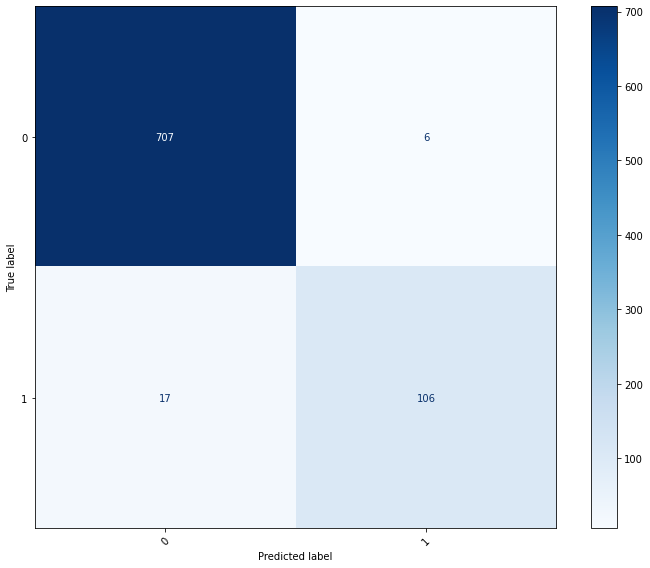

In [57]:
# Plotting a confusion matrix
cm = confusion_matrix(predicted_labels_array, labels_test)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'text.color': "black",
                     'axes.labelcolor': "black", 'xtick.color': "black", 'ytick.color': "black"})
fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('white')
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xticks(rotation = 45)

In [ ]:
# As files on google colab are removed after the runtime is disconnected,
# it is possible to pack the saved model into a .zip archive
# and download the archive to save the model locally.
#!zip -r /content/bert.zip /content/model_bert.tf

In [ ]:
#from google.colab import files
#files.download("/content/bert.zip")